# Trining and Prediction with Keras in AI Platform

<img src="https://storage.googleapis.com/cloud-samples-data/ml-engine/census/keras-tensorflow-cmle.png" alt="Keras, TensorFlow, and AI Platform logos" width="300px">

This notebook collection is inspired by the tutorial [Getting started: Training and prediction with Keras](https://cloud.google.com/ml-engine/docs/tensorflow/getting-started-keras)

## Before you begin

You must do several things before you can train and deploy a model in
AI Platform:

* Set up your local development environment.
* Set up a GCP project with billing and the necessary
  APIs enabled.
* Authenticate your GCP account in this notebook.
* Create a Cloud Storage bucket to store your training package and your
  trained model.
  
### Set up your local development environment

### Set up your GCP project

1. [Select or create a GCP project.](https://console.cloud.google.com/home/dashboard?project=skydipper-196010&organizationId=167176151391)

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the AI Platform ("Cloud Machine Learning Engine") and Compute Engine APIs.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component)

4. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

In [1]:
PROJECT_ID = "skydipper-196010" 
! gcloud config set project $PROJECT_ID

Updated property [core/project].


### Authenticate your GCP account

1. In the GCP Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. From the **Service account** drop-down list, select **New service account**.

3. In the **Service account name** field, enter a name.

4. From the **Role** drop-down list, select
   **Machine Learning Engine > ML Engine Admin**

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [2]:
%env GOOGLE_APPLICATION_CREDENTIALS '/Users/ikersanchez/Vizzuality/Keys/Skydipper/skydipper-a7dd533b1f5e.json'

env: GOOGLE_APPLICATION_CREDENTIALS='/Users/ikersanchez/Vizzuality/Keys/Skydipper/skydipper-a7dd533b1f5e.json'


### Create a Cloud Storage [bucket](https://console.cloud.google.com/storage/browser/skydipper_materials?project=skydipper-196010&organizationId=167176151391)

**The following steps are required, regardless of your notebook environment.**

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. AI Platform runs
the code from this package. In this tutorial, AI Platform also saves the
trained model that results from your job in the same bucket. You can then
create an AI Platform model verison based on this output in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets. 

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Cloud
AI Platform services are
available](https://cloud.google.com/ml-engine/docs/tensorflow/regions). You may
not use a Multi-Regional Storage bucket for training with AI Platform.

In [3]:
BUCKET_NAME = "skydipper_materials" #@param {type:"string"}
REGION = "europe-west1" #@param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
#! gsutil mb -l $REGION gs://$BUCKET_NAME

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [4]:
! gsutil ls -al gs://$BUCKET_NAME

      3178  2019-03-07T15:06:20Z  gs://skydipper_materials/classifier.pkl#1551971180525272  metageneration=1
 199053824  2018-11-21T15:37:24Z  gs://skydipper_materials/wi_teams_tensorflow_model.tgz#1542814644296272  metageneration=1
                                 gs://skydipper_materials/gee_data/
                                 gs://skydipper_materials/gee_data_2/
                                 gs://skydipper_materials/gee_data_TFRecords/
                                 gs://skydipper_materials/keras-job-dir/
                                 gs://skydipper_materials/mist_tfrecords/
                                 gs://skydipper_materials/movie-tiles/
                                 gs://skydipper_materials/tf-keras-tf.data-numpy/
                                 gs://skydipper_materials/tf-keras-tfrecords/
TOTAL: 2 objects, 199057002 bytes (189.84 MiB)


## Part 1. Quickstart for training in AI Platform

This section of the tutorial walks you through submitting a training job to Cloud
AI Platform. This job runs sample code that uses Keras to train a deep convolutional neural
network on the [MNIST data](https://en.wikipedia.org/wiki/MNIST_database). It outputs the trained model as a
[TensorFlow SavedModel
directory](https://www.tensorflow.org/guide/saved_model#save_and_restore_models)
in your Cloud Storage bucket.

### Get training code and dependencies

The training code is located in the `AI_Platform/tf-keras/TFRecords` directory

In [5]:
# Set the working directory to the sample code directory
%cd AI_Platform/tf-keras/TFRecords

/Users/ikersanchez/Vizzuality/GitHub/Skydipper/cnn-models/notebooks/AI_Platform/tf-keras/TFRecords


Notice that the training code is structured as a Python package in the
`trainer/` subdirectory:

In [6]:
# `ls` shows the working directory's contents. The `p` flag adds trailing 
# slashes to subdirectory names. The `R` flag lists subdirectories recursively.
! ls -pR

README.md             hptuning_config.yaml  setup.py
config.yaml           requirements.txt      trainer/

./trainer:
__init__.py  __pycache__/ model.py     task.py      util.py

./trainer/__pycache__:
__init__.cpython-36.pyc  task.cpython-36.pyc
model.cpython-36.pyc     util.cpython-36.pyc


Run the following cell to install Python dependencies needed to train the model locally. When you run the training job in AI Platform,
dependencies are preinstalled based on the [runtime
verison](https://cloud.google.com/ml-engine/docs/tensorflow/runtime-version-list)
you choose.

In [ ]:
! pip install -r requirements.txt

### Train your model locally

Before training on AI Platform, train the job locally to verify the file
structure and packaging is correct.

For a complex or resource-intensive job, you
may want to train locally on a small sample of your dataset to verify your code.
Then you can run the job on AI Platform to train on the whole dataset.

This sample runs a relatively quick job on a small dataset, so the local
training and the AI Platform job run the same code on the same data.

Run the following cell to train a model locally:

In [ ]:
# Explicitly tell `gcloud ai-platform local train` to use Python 3 
! gcloud config set ml_engine/local_python $(which python3)

# This is similar to `python -m trainer.task --job-dir local-training-output`
# but it better replicates the AI Platform environment, especially for
# distributed training (not applicable here).
! gcloud ai-platform local train \
  --package-path trainer \
  --module-name trainer.task \
  --job-dir local-training-output 

### Train your model using AI Platform

Next, submit a training job to AI Platform. This runs the training module
in the cloud and exports the trained model to Cloud Storage.

First, give your training job a name and choose a directory within your Cloud
Storage bucket for saving intermediate and output files:

In [7]:
JOB_NAME = 'keras_job_with_tfrecords_v4'
JOB_DIR = 'gs://' + BUCKET_NAME + '/tf-keras-tfrecords'

Run the following command to package the `trainer/` directory, upload it to the
specified `--job-dir`, and instruct AI Platform to run the
`trainer.task` module from that package.

The `--stream-logs` flag lets you view training logs in the cell below. You can
also see logs and other job details in the GCP Console.

In [ ]:
! gcloud ai-platform jobs submit training $JOB_NAME \
  --package-path trainer/ \
  --module-name trainer.task \
  --region $REGION \
  --python-version 3.5 \
  --runtime-version 1.13 \
  --job-dir $JOB_DIR \
  --stream-logs

**Cancel a running AI Platform job**

In [ ]:
!gcloud ai-platform jobs cancel $JOB_NAME

### Hyperparameter tuning

You can optionally perform hyperparameter tuning by using the included
`hptuning_config.yaml` configuration file. This file tells AI Platform to tune the batch size and learning rate for training over multiple trials to maximize accuracy.

In this example, the training code uses a [Tensorboard
callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard),
which [creates TensorFlow `Summary`
`Event`s](https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter#add_summary)
during training. AI Platform uses these events to track the metric you want to
optimize. Learn more about [hyperparmeter tuning in
AI Platform Training](https://cloud.google.com/ml-engine/docs/tensorflow/hyperparameter-tuning-overview).

In [ ]:
! gcloud ai-platform jobs submit training $JOB_NAME-hpt \
  --config hptuning_config.yaml \
  --package-path trainer/ \
  --module-name trainer.task \
  --region $REGION \
  --python-version 3.5 \
  --runtime-version 1.13 \
  --job-dir $JOB_DIR \
  --stream-logs

### Using GPUs
AI Platform lets you run any TensorFlow training application on a GPU-enabled machine. Learn more about [using GPUs for training models in the cloud](https://cloud.google.com/ml-engine/docs/tensorflow/using-gpus#submit-job).

**Submitting the training job**

1. Define a `config.yaml` file that describes the GPU options you want. The structure of the YAML file represents the [Job resource](https://cloud.google.com/ml-engine/reference/rest/v1/projects.jobs). Below are two examples of `config.yaml` files.

The first example shows a configuration file for a training job using AI Platform machine types, some of which include GPUs:

```yaml
trainingInput:
  scaleTier: CUSTOM
  # Configure a master worker with 4 K80 GPUs
  masterType: complex_model_m_gpu
  # Configure 9 workers, each with 4 K80 GPUs
  workerCount: 9
  workerType: complex_model_m_gpu
  # Configure 3 parameter servers with no GPUs
  parameterServerCount: 3
  parameterServerType: large_model
  ```
2. Use the gcloud command to submit the job, including a --config argument pointing to your config.yaml file. 

In [8]:
! gcloud ai-platform jobs submit training $JOB_NAME \
  --package-path trainer/ \
  --module-name trainer.task \
  --region $REGION \
  --config config.yaml \
  --python-version 3.5 \
  --runtime-version 1.13 \
  --job-dir $JOB_DIR \
  --stream-logs

Job [keras_job_with_tfrecords_v4] submitted successfully.
INFO	2019-05-24 17:03:33 +0200	service		Validating job requirements...
INFO	2019-05-24 17:03:33 +0200	service		Job creation request has been successfully validated.
INFO	2019-05-24 17:03:33 +0200	service		Job keras_job_with_tfrecords_v4 is queued.
INFO	2019-05-24 17:03:33 +0200	service		Waiting for job to be provisioned.
INFO	2019-05-24 17:03:35 +0200	service		Waiting for training program to start.
INFO	2019-05-24 17:05:05 +0200	master-replica-0		Running task with arguments: --cluster={"master": ["127.0.0.1:2222"]} --task={"type": "master", "index": 0} --job={  "scale_tier": "BASIC_GPU",  "package_uris": ["gs://skydipper_materials/tf-keras-tfrecords/packages/4361b710269fa457e0be852d9fea806ac335be400a700306b23884edd1b8f73b/trainer-0.1.tar.gz"],  "python_module": "trainer.task",  "region": "europe-west1",  "runtime_version": "1.13",  "job_dir": "gs://skydipper_materials/tf-keras-tfrecords",  "run_on_raw_vm": true,  "python_version

**Cancel a running AI Platform job**

In [ ]:
!gcloud ai-platform jobs cancel $JOB_NAME

## Part 2. Quickstart for online predictions in AI Platform

This section shows how to use AI Platform and your trained model from Part 1
to predict a person's income bracket from other Census information about them.

### Create model and version resources in AI Platform

To serve online predictions using the model you trained and exported in Part 1,
create a *model* resource in AI Platform and a *version* resource
within it. The version resource is what actually uses your trained model to
serve predictions. This structure lets you adjust and retrain your model many times and
organize all the versions together in AI Platform. Learn more about [models
and
versions](https://cloud.google.com/ml-engine/docs/tensorflow/projects-models-versions-jobs).

First, name and create the model resource:

In [9]:
MODEL_NAME = "keras_tfrecords_model"

! gcloud ai-platform models create $MODEL_NAME \
  --regions $REGION

Created ml engine model [projects/skydipper-196010/models/keras_tfrecords_model].


Next, create the model version. The training job from Part 1 exported a timestamped
[TensorFlow SavedModel
directory](https://www.tensorflow.org/guide/saved_model#structure_of_a_savedmodel_directory)
to your Cloud Storage bucket. AI Platform uses this directory to create a
model version. Learn more about [SavedModel and
AI Platform](https://cloud.google.com/ml-engine/docs/tensorflow/deploying-models).

You may be able to find the path to this directory in your training job's logs.
Look for a line like:

```
Model exported to:  gs://<your-bucket-name>/keras-job-dir/keras_export/1545439782
```

Execute the following command to identify your SavedModel directory and use it to create a model version resource:

In [10]:
MODEL_VERSION = "v1"

# Get a list of directories in the `keras_export` parent directory
KERAS_EXPORT_DIRS = ! gsutil ls $JOB_DIR/keras_export/

# Pick the directory with the latest timestamp, in case you've trained
# multiple times
SAVED_MODEL_PATH = KERAS_EXPORT_DIRS[-1]

# Create model version based on that SavedModel directory
! gcloud ai-platform versions create $MODEL_VERSION \
  --model $MODEL_NAME \
  --runtime-version 1.13 \
  --python-version 3.5 \
  --framework tensorflow \
  --origin $SAVED_MODEL_PATH

Creating version (this might take a few minutes)......done.


### Prepare input for prediction

To receive valid and useful predictions, you must preprocess input for prediction in the same way that training data was preprocessed. In a production
system, you may want to create a preprocessing pipeline that can be used identically at training time and prediction time.

For this exercise, use the training package's data-loading code to select a random sample from the evaluation data. This data is in the form that was used to evaluate accuracy after each epoch of training, so it can be used to send test predictions without further preprocessing:

In [11]:
from tensorflow import keras
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt

(_, _), (eval_x, eval_y) = keras.datasets.mnist.load_data()

# We convert the input data to (10000, 28, 28, 1), float32 and normalize our data values to the range [0, 1].
eval_x = eval_x.reshape(eval_x.shape[0], eval_x.shape[1], eval_x.shape[2], 1)
eval_x = eval_x.astype('float32')
eval_x /= 255

# Preprocess class labels 
eval_y = eval_y.astype(np.int32)
eval_y = np_utils.to_categorical(eval_y, 10)

Using TensorFlow backend.


In [12]:
print(eval_x.shape)
print(eval_y.shape)

(10000, 28, 28, 1)
(10000, 10)


**[Formatting your input for online prediction](https://cloud.google.com/ml-engine/docs/tensorflow/online-predict#formatting_instances_as_json_strings)**

Formatting instances as JSON strings

The basic format for online prediction is a list of instance data tensors. These can be either plain lists of values or members of a JSON object, depending on how you configured your inputs in your training application.

This example shows an input tensor and an instance key:

```json
{"values": [1, 2, 3, 4], "key": 1}
```

The makeup of the JSON string can be complex as long as it follows these rules:

- The top level of instance data must be a JSON object—a dictionary of key/value pairs.

- Individual values in an instance object can be strings, numbers, or lists. You cannot embed JSON objects.

- Lists must contain only items of the same type (including other lists). You may not mix string and numerical values.

You pass input instances for online prediction as the message body for the projects.predict call. Learn more about the [request body's formatting requirements](https://cloud.google.com/ml-engine/docs/v1/predict-request).

In [13]:
eval_x = eval_x[:2, :, :, :]
eval_y = eval_y[:2,:]

Export the prediction input to a newline-delimited JSON file:

In [14]:
import json

img = eval_x.tolist()

with open('prediction_input.json', 'w', encoding='utf-8') as f:
    for i, row in enumerate(img):
        instance = {"input_1" : row}
        json.dump(instance, f , sort_keys=True)
        f.write("\n")

In [15]:
eval_x.shape

(2, 28, 28, 1)

The `gcloud` command-line tool accepts newline-delimited JSON for online
prediction, and this particular Keras model expects a flat list of
numbers for each input example.

AI Platform requires a different format when you make online prediction requests to the REST API without using the `gcloud` tool. The way you structure
your model may also change how you must format data for prediction. Learn more
about [formatting data for online
prediction](https://cloud.google.com/ml-engine/docs/tensorflow/prediction-overview#prediction_input_data).

### Submit the online prediction request
Use `gcloud` to submit your online prediction request.

In [16]:
! gcloud ai-platform predict \
  --model $MODEL_NAME \
  --version $MODEL_VERSION \
  --json-instances prediction_input.json

DENSE_1
[2.023962551895666e-26, 8.663734465809003e-29, 6.277401515264458e-11, 1.1011289536427826e-12, 1.8976428187556588e-17, 8.066099878120263e-21, 0.0, 1.0, 4.1366337980887347e-14, 1.5203291403587116e-10]
[1.363888169070293e-10, 9.00282556837162e-11, 1.0, 2.935722598351731e-08, 4.012940855251541e-19, 5.144773936570108e-15, 4.51758503652519e-13, 1.8926873956992551e-13, 6.34812202804369e-09, 2.4135806502589514e-22]


Do the predicted income brackets match the actual ones? Run the following cell
to see the true labels.

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


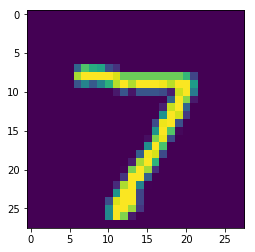

In [17]:
print(eval_y[0])
plt.imshow(eval_x[0,:,:,0]);

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


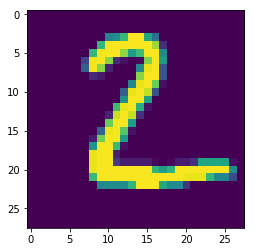

In [18]:
print(eval_y[1])
plt.imshow(eval_x[1,:,:,0]);